In [1]:
import uproot 
import numpy as np
import coffea
from coffea.nanoaod import NanoEvents
from coffea.nanoaod.methods.leptons import *
from coffea import hist
import matplotlib.pyplot as plt

In [2]:
fname="/uscms/home/ahall/nobackup/public/forTamas/iDM_nanoaod.root"
events = NanoEvents.from_file(fname,methods={"ElectronBPark":Electron})

In [127]:
#cuts on MET and Jet
MET_mask = events.MET.pt >120
Jet_mask = events.Jet.pt.max() > 80
MET_Jet_mask = MET_mask & Jet_mask

soft_eles = events[MET_Jet_mask].ElectronBPark

GenPart_mask = ((abs(events[MET_Jet_mask].GenPart.pdgId) == 11) 
               & (events[MET_Jet_mask].GenPart.parent.pdgId == 1000023)
               & (events[MET_Jet_mask].GenPart.status == 1) 
               & (events[MET_Jet_mask].GenPart.hasFlags(["fromHardProcess", "isFirstCopy"])))

#delta_r criteria for matched and unmatched electrons
eles = soft_eles.cross(events[MET_Jet_mask].GenPart[GenPart_mask], nested=True)
matched_mask = ((eles.i0.delta_r(eles.i1)).min() < 0.005)
unmatched_mask = ((eles.i0.delta_r(eles.i1)).min() >= 0.005)
matched_eles = soft_eles[matched_mask & (soft_eles.isPF == False)]
unmatched_eles = soft_eles[unmatched_mask & (soft_eles.isPF == False)]

In [128]:
print(len(matched_eles.flatten()))
print(len(soft_eles[(eles.i0.delta_r(eles.i1)).min() < 0.005].flatten()))
x=0
for i in matched_eles.mvaId.flatten():
    if i==20:
        x=x+1
print(x)

508
792
0


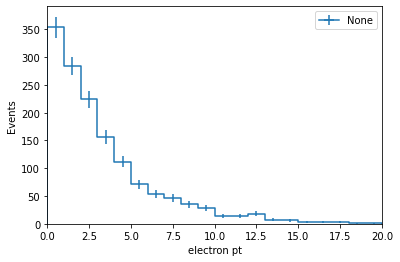

In [104]:
# masked Gen ele pt.
histo_gen_pt= hist.Hist(
            "Events",
            hist.Bin("ele_pt", "electron pt", 20, 0, 20),
        )
histo_gen_pt.fill(ele_pt=events[MET_Jet_mask].GenPart[GenPart_mask].pt.flatten())
hist.plot1d(histo_gen_pt)

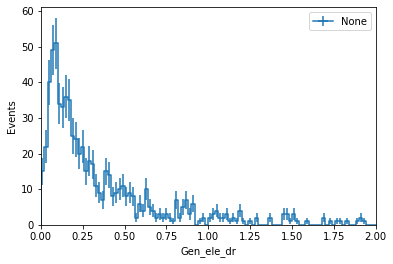

In [105]:
# masked Gen Ele dr
histo_gen_dr = hist.Hist(
            "Events",
            hist.Bin("gen_ele_dr", "Gen_ele_dr", 100, 0, 2),
        )
genEle_pairs = events[MET_Jet_mask].GenPart[GenPart_mask].distincts(nested=True)
histo_gen_dr.fill(gen_ele_dr=genEle_pairs.i0.delta_r(genEle_pairs.i1).min().flatten())
hist.plot1d(histo_gen_dr)

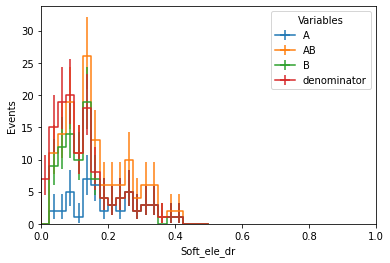

In [118]:
matched_pairs = matched_eles.distincts(nested=True)

# applying pt cut only on one of the electrons from the pair
matched_pairsA = matched_pairs[(matched_pairs.i0.pt < 5) & (matched_pairs.i0.pt > 1)]
matched_pairsB = matched_pairs[(matched_pairs.i1.pt < 5) & (matched_pairs.i1.pt > 1)]

delta_r = (matched_pairs.i0.delta_r(matched_pairs.i1)).min()
delta_rA = (matched_pairsA.i0.delta_r(matched_pairsA.i1)).min()
delta_rB = (matched_pairsB.i0.delta_r(matched_pairsB.i1)).min()

#AB contains duplicates where both values are within pt range
delta_rAB = np.append(delta_rA.flatten().tolist(), delta_rB.flatten().tolist())

histo_dr_all = hist.Hist(
            "Events",
            hist.Cat("variables", "Variables"),
            hist.Bin("soft_ele", "Soft_ele_dr", 20, 0, 0.5),
        )

# denominator with no pt cut
histo_dr_all.fill(variables="denominator", soft_ele = delta_r.flatten())
# with pt cuts
histo_dr_all.fill(variables="A", soft_ele = delta_rA.flatten())
histo_dr_all.fill(variables="B", soft_ele = delta_rB.flatten())
histo_dr_all.fill(variables="AB", soft_ele = delta_rAB)

hist.plot1d(histo_dr_all)

In [107]:
def cut(electrons):
    return electrons[
        (electrons.pt > 1) & (electrons.pt<5)
    ]

# def cut1(electrons):
#     return electrons[
#         (electrons.pt > 1) & (electrons.pt<5)
#         & (abs(electrons.eta) < 1.4)
#         & (electrons.ip3d < 5)
#         & (abs(electrons.dz) < 15)
#         & (abs(electrons.dxy) < 0.1)
#         & (electrons.trkRelIso < 15)#Why is this so significant
#     ]
# def cut2(electrons):
#     return electrons[
#         (electrons.pt > 1) & (electrons.pt<5)
#         #& (abs(electrons.eta) < 1.4)
#         & (electrons.ip3d < 0.5)
#         & (electrons.sip3d < 100)
#         & (abs(electrons.dz) < 0.25)
#          & (abs(electrons.dxy) < 0.3)
#         &(electrons.ptBiased > 0)
#         & (electrons.unBiased >0)
#       #& (electrons.trkRelIso < 15)#Irrelevant
#     ]

def cut_loose(electrons):
    return electrons[
        (electrons.pt > 1) & (electrons.pt<5)
        & (electrons.mvaId > 0)
    ]

In [108]:
#----------------------------------------------------------------------------
# pt efficiency curves
#----------------------------------------------------------------------------
histo_all = hist.Hist(
            "All",
            hist.Cat("variables", "Variables"),
            hist.Bin("soft_ele", "Soft_ele_pt", 50, 0, 5),
        )

histo_all.fill(variables="denominator", soft_ele = cut(matched_eles).pt.flatten())

/uscms/home/tamasan/miniconda3/envs/FireHydrant/lib/python3.8/site-packages/coffea/hist/plot.py:355: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom


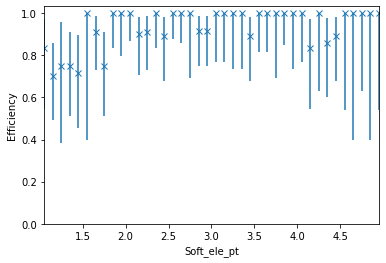

In [109]:
histo_loose = hist.Hist(
            "Efficiency",
            hist.Cat("variables", "Variables"),
            hist.Bin("soft_ele", "Soft_ele_pt", 50, 0, 5),
        )
histo_loose.fill(variables="looseMVA", soft_ele = cut_loose(matched_eles).pt.flatten())
%matplotlib inline
hist.plotratio(num=histo_loose.integrate("variables"), denom=histo_all.integrate("variables"), error_opts={"marker": "x"})

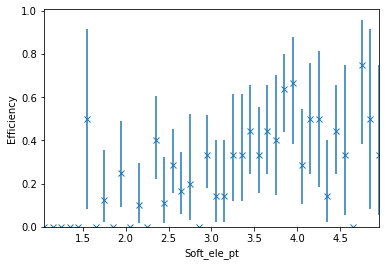

In [110]:
def cut_tight(electrons):
    return electrons[
        (electrons.pt > 1) & (electrons.pt<5)
        & (electrons.mvaId > 5)
    ]

histo_tight = hist.Hist(
            "Efficiency",
            hist.Cat("variables", "Variables"),
            hist.Bin("soft_ele", "Soft_ele_pt", 50, 0, 5),
        )
histo_tight.fill(variables="looseMVA", soft_ele = cut_tight(matched_eles).pt.flatten())
%matplotlib inline
hist.plotratio(num=histo_tight.integrate("variables"), denom=histo_all.integrate("variables"), error_opts={"marker": "x"})

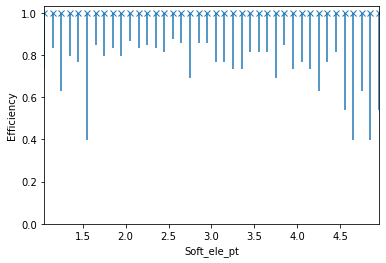

In [111]:
def cut_dxy(electrons):
    return electrons[
        (electrons.pt > 1) & (electrons.pt<5)
        & (abs(electrons.dxy) < 0.3)
    ]

histo_dxy_eff = hist.Hist(
            "Efficiency",
            hist.Cat("variables", "Variables"),
            hist.Bin("soft_ele", "Soft_ele_pt", 50, 0, 5),
        )
histo_dxy_eff.fill(variables="dxy", soft_ele = cut_dxy(matched_eles).pt.flatten())
%matplotlib inline
hist.plotratio(num=histo_dxy_eff.integrate("variables"), denom=histo_all.integrate("variables"), error_opts={"marker": "x"})

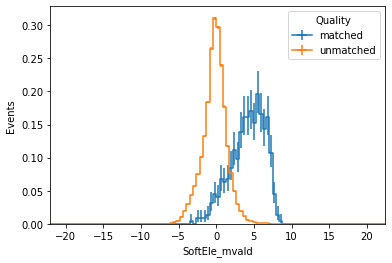

In [112]:
histo_mvaId = hist.Hist(
            "Events ",
            hist.Cat("quality", "Quality"),
            hist.Bin("soft_unmatched_ele", "SoftEle_mvaId", 100, -22, 22),
        )

histo_mvaId.fill(quality ="matched", soft_unmatched_ele=matched_eles.mvaId.flatten())
histo_mvaId.fill(quality ="unmatched", soft_unmatched_ele=unmatched_eles.mvaId.flatten())


%matplotlib inline
hist.plot1d(histo_mvaId, overflow = "over", density = True)

(-0.4, 0.4)

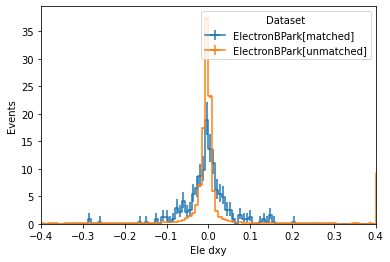

In [113]:
#guess cut: abs(0.3)
histo_dxy = hist.Hist(
            "Events",
            hist.Cat("dataset", "Dataset"),
            hist.Bin("dxy", "Ele dxy", 100, -0.4, 0.4),
        )
histo_dxy.fill(dataset ="ElectronBPark[matched]", dxy = cut(matched_eles).dxy.flatten())
histo_dxy.fill(dataset ="ElectronBPark[unmatched]", dxy = cut(unmatched_eles).dxy.flatten())
%matplotlib inline
ax_dxy = hist.plot1d(histo_dxy, overflow = "over", density = True)
ax_dxy.set_xlim(right=0.4, left=-0.4)

(-0.5, 0.5)

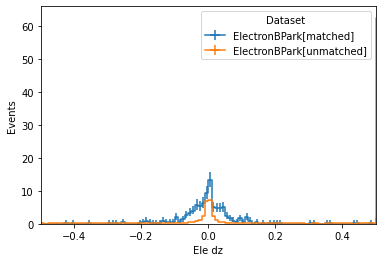

In [114]:
#guess cut: abs(0.25)
histo_dz = hist.Hist(
            "Events",
            hist.Cat("dataset", "Dataset"),
            hist.Bin("dz", "Ele dz", 100, -0.5, 0.5),
        )
histo_dz.fill(dataset ="ElectronBPark[matched]", dz = cut(matched_eles).dz.flatten())
histo_dz.fill(dataset ="ElectronBPark[unmatched]", dz = cut(unmatched_eles).dz.flatten())
%matplotlib inline
ax_dz = hist.plot1d(histo_dz, density = True, overflow = "over")
ax_dz.set_xlim(right=0.5, left=-0.5)

In [75]:
matched_eles

<ElectronArray [[] [<ElectronBPark 594>] [] ... [] [<ElectronBPark 302237>] []] at 0x7f6d3dba98b0>